# Transfer learning

Transfer learning figure used in Wellcome grant.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams['font.family'] = "Helvetica"
matplotlib.rcParams['font.size'] = 8.18
matplotlib.rcParams['figure.facecolor'] = 'white'

def fix_bytes(df):

    for col in df.columns:
        if df[col].dtype == object:
            df[col] = df[col].str.replace("b'", '').str.replace("'", '')

    return df


Load in and preprocess data.

In [2]:
paths = [
    f'../results/ResNet6_dataset-gmf_112x112_emo_target-id_epoch-050_perf.tsv',
    f'../results/ResNet6_dataset-gmf_112x112_emo_target-gender_epoch-010_perf.tsv'
]

dfs = []
for path in paths:
    df = pd.read_csv(path, sep='\t')
    df['target'] = path.split('/')[-1].split('_target-')[1].split('_')[0]
    dfs.append(df)

df = pd.concat(dfs, axis=0)
df_rot = df.query("factor in ['xr', 'yr', 'zr']").groupby(['feature_nr', 'layername', 'layer', 'operation', 'op_nr', 'target']).mean(numeric_only=True).reset_index().assign(factor='rot')
df_trans = df.query("factor in ['xt', 'yt', 'zt']").groupby(['feature_nr', 'layername', 'layer', 'operation', 'op_nr', 'target']).mean(numeric_only=True).reset_index().assign(factor='trans')
df_light = df.query("factor in ['xl', 'yl']").groupby(['feature_nr', 'layername', 'layer', 'operation', 'op_nr', 'target']).mean(numeric_only=True).reset_index().assign(factor='lights')
df_tex = df.query("factor == 'tex'").groupby(['layername', 'layer', 'operation', 'op_nr', 'target']).max(numeric_only=True).reset_index().assign(factor='tex')
df_shape = df.query("factor == 'shape'").groupby(['layername', 'layer', 'operation', 'op_nr', 'target']).max(numeric_only=True).reset_index().assign(factor='shape')

df = pd.concat([
    df_rot,
    df_trans,
    df_light,
    df_tex,
    df_shape,
    df.query("factor not in ['xr', 'yr', 'zr', 'xt', 'yt', 'zt', 'xl', 'yl', 'tex', 'shape']")
])

df = df.replace({'bg': 'backgr.', 'rot': 'rotation', 'trans': 'transl.', 'lights': 'lighting', 'tex': 'texture', 'shape': 'shape', 'id': 'face ID', 'gend': 'gender', 'ethn': 'ethn.', 'emo': 'emotion'})
df = df.query("layername != 'layer00_input'").query("factor in ['gender', 'face ID']")

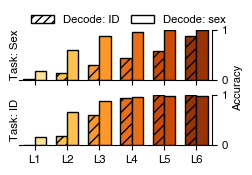

In [4]:
n_layers = df['layername'].nunique()
layernames = [f'L{i+1}' for i in range(n_layers)]
factors = ['gender', 'face ID']
n_factors = len(factors)
cmap = sns.color_palette("YlOrBr", n_colors=len(layernames) + 1)

fig, axes = plt.subplots(nrows=2, figsize=(2.5, 1.5), sharex=True, sharey=True)
ylabels = ['Sex', 'ID']
for i, target in enumerate(['gender', 'face ID']):
    bar = sns.barplot(x='layername', y='corr', hue='factor', ax=axes[i], data=df.query("target == @target"), width=0.7)
    for ii, patch in enumerate(bar.patches):
        patch.set_facecolor(cmap[ii % len(layernames) + 1])
        patch.set_edgecolor('black')
        if ii < len(layernames):
            patch.set_hatch('///')

    axes[i].set_xlabel('')
    axes[i].set_ylabel(f'Task: {ylabels[i]}', labelpad=-1)
    axes[i].yaxis.tick_right()
    axes[i].spines['left'].set_visible(False)
    axes[i].spines['top'].set_visible(False)
    axes[i].legend([], frameon=False)
    axes[i].set_yticks([0, 1])
    axes[i].set_yticklabels(['0', '1'])

axes[-1].set_ylim(0, 1.)
axes[-1].set_xticklabels(layernames)
fig.text(1, 0.5, 'Accuracy', va='center', ha='center', fontsize=8, rotation=90)

fig.subplots_adjust(hspace=0.3)
handles = [matplotlib.patches.Patch(facecolor='white', hatch='////', edgecolor='k'), matplotlib.patches.Patch(facecolor='white', edgecolor='k')]
fig.legend(handles, ['Decode: ID', 'Decode: sex'], alignment='left', loc='upper left', ncol=2, bbox_to_anchor=(0.135, 1.05), frameon=False, columnspacing=1)
fig.savefig('./figures/transfer_learning.pdf', bbox_inches='tight')